# ANN Constraint Training Test with Cross Validation

In [168]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import argparse
import scipy.io
import os

In [169]:
# Define the classifier architecture
class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.func1 = nn.Sigmoid()
        
        self.fc2 = nn.Linear(64, 32)
        self.func2 = nn.Sigmoid()
        
        self.fc3 = nn.Linear(32, 16)
        self.func3 = nn.Sigmoid()
        
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.func1(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.func2(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.func3(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.relu(x)
        
        #x = self.dropout(x)
        
        return x
    
get_dropout = Classifier(7).dropout
dropout_number = str(get_dropout)

In [187]:
mat_input = scipy.io.loadmat('C:/Users/D3H8678/Master_Thesis/mooinverter/TestFolder/MOO/inverter/ANN_Training/Data_generated/10000_input_data.mat')
mat_target = scipy.io.loadmat('C:/Users/D3H8678/Master_Thesis/mooinverter/TestFolder/MOO/inverter/ANN_Training/Constraint Data/10000_Target.mat')
#Get scaled input and Target data
input_scaled = mat_input.get('input_scaled')

output = mat_target.get('Target')

amount_of_rows = 0

# Generate random indices for the rows to remove
indices_to_remove = np.random.choice(input_scaled.shape[0], amount_of_rows, replace=False)

# Remove the specified rows from input_scaled and output
input_subset = np.delete(input_scaled, indices_to_remove, axis=0)
output_subset = np.delete(output, indices_to_remove, axis=0)

# Verify the shape of the resulting subsets
print(input_subset.shape)
print(output_subset.shape)

(10000, 7)
(10000, 1)


In [171]:
# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set data and target
data = torch.Tensor(input_subset)
target = torch.Tensor(output_subset)

# Define the number of folds
k = 10

# Create the k-fold cross-validation iterator
kf = KFold(n_splits=k)

# Initialize lists to store the validation and test accuracies
val_accuracies = []
test_accuracies = []
best_test_accuracy = 0.0

############################### Cross Validation ###################################### 
'''
# Old Code 80/10/10
# Split the data into training, validation, and test sets for the current fold
train_data, val_test_data = data[train_index], data[test_index]
train_target, val_test_target = target[train_index], target[test_index]

# Further split the validation and test sets
val_index, test_index = train_test_split(
    range(len(val_test_data)), test_size=0.5, random_state=42
)
val_data, test_data = val_test_data[val_index], val_test_data[test_index]
val_target, test_target = val_test_target[val_index], val_test_target[test_index]

'''
    
# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(data)):
    print(f"Fold [{fold+1}/{k}]")

    # Split the data into training and validation/test sets for the current fold
    train_data, val_test_data = data[train_index], data[test_index]
    train_target, val_test_target = target[train_index], target[test_index]

    # Further split the validation and test sets
    val_data, test_data, val_target, test_target = train_test_split(
        val_test_data, val_test_target, test_size=999, random_state=42
    )

    # Further split the training set into training and additional validation sets
    train_data, val_data, train_target, val_target = train_test_split(
        train_data, train_target, test_size=1000, random_state=42
    )

    # Calculate the sizes of the training, validation, and test sets
    train_size = len(train_data)
    val_size = len(val_data)
    test_size = len(test_data)


    # Create data loaders
    train_dataset = TensorDataset(train_data, train_target)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataset = TensorDataset(val_data, val_target)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_dataset = TensorDataset(test_data, test_target)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        

############################### PRINTS ###############################################

    # Print the sizes of the training, validation, and test sets
    print(f"Training set size: {train_size}")
    print(f"Validation set size: {val_size}")
    print(f"Testing set size: {test_size}")


############################### Training Set ######################################                                   

    # Initialize the model
    model = Classifier(input_size=7).to(device)

    # Define the loss function and optimizer
    lr = 0.01
    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(model.parameters(), lr)
    string_loss = "MSE"
    string_optimizer = "RMS"

    # Training loop
    num_epochs = 200
    best_val_loss = float("inf")
    train_losses = []
    patience = 10  # Number of epochs to wait for improvement
    no_improvement = 0  # Counter for epochs without improvement
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        # Training
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            labels = labels.squeeze()
            loss = criterion(outputs.squeeze(), labels.float())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        # Stop epoch if validation doesn't improve
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                labels = labels.squeeze()
                loss = criterion(outputs.squeeze(), labels.float())

                val_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Append train loss to the list
        val_loss /= len(val_loader)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )
        
############################### Validation Set ######################################       

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_validation.pt")

    # Test the model on the validation set
    model.load_state_dict(torch.load("best_model_validation.pt"))
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = (correct / total) * 100
        print(f"Validation Accuracy: {accuracy:.2f}%")
        val_accuracies.append(accuracy)

############################### Test Set ######################################           
        
    # Test the model on the test set
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = (correct / total) * 100
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        test_accuracies.append(test_accuracy)

        # Save the best model based on test accuracy
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model_fold_index = fold
            string = "best_model_{0}_epoch_{1}_loss_{2}_optimizer_{3}_lr_{4}_dropout_{5}_data-size_{6}.pt".format(
                best_test_accuracy, num_epochs, string_loss, string_optimizer, lr, dropout_number[10:14], data.size(0))
            torch.save(model.state_dict(), string)

Fold [1/10]
Training set size: 8000
Validation set size: 1000
Testing set size: 999
Epoch [1/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [2/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [3/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [4/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [5/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [6/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [7/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [8/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [9/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [10/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [11/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [12/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [13/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [14/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [15/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [16/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [17/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [18/200], Train Lo

Epoch [154/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [155/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [156/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [157/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [158/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [159/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [160/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [161/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [162/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [163/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [164/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [165/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [166/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [167/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [168/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [169/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [170/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [171/200], Train Loss: 0.6496, Val Loss: 0.6719
Epoch [172/200], Train Loss:

Epoch [106/200], Train Loss: 0.0315, Val Loss: 0.0403
Epoch [107/200], Train Loss: 0.0306, Val Loss: 0.0386
Epoch [108/200], Train Loss: 0.0315, Val Loss: 0.0407
Epoch [109/200], Train Loss: 0.0306, Val Loss: 0.0376
Epoch [110/200], Train Loss: 0.0300, Val Loss: 0.0396
Epoch [111/200], Train Loss: 0.0290, Val Loss: 0.0438
Epoch [112/200], Train Loss: 0.0306, Val Loss: 0.0385
Epoch [113/200], Train Loss: 0.0295, Val Loss: 0.0427
Epoch [114/200], Train Loss: 0.0299, Val Loss: 0.0470
Epoch [115/200], Train Loss: 0.0294, Val Loss: 0.0435
Epoch [116/200], Train Loss: 0.0291, Val Loss: 0.0381
Epoch [117/200], Train Loss: 0.0309, Val Loss: 0.0377
Epoch [118/200], Train Loss: 0.0285, Val Loss: 0.0329
Epoch [119/200], Train Loss: 0.0292, Val Loss: 0.0402
Epoch [120/200], Train Loss: 0.0280, Val Loss: 0.0394
Epoch [121/200], Train Loss: 0.0277, Val Loss: 0.0374
Epoch [122/200], Train Loss: 0.0282, Val Loss: 0.0402
Epoch [123/200], Train Loss: 0.0280, Val Loss: 0.0381
Epoch [124/200], Train Loss:

Epoch [57/200], Train Loss: 0.0529, Val Loss: 0.0600
Epoch [58/200], Train Loss: 0.0516, Val Loss: 0.0575
Epoch [59/200], Train Loss: 0.0517, Val Loss: 0.0560
Epoch [60/200], Train Loss: 0.0503, Val Loss: 0.0624
Epoch [61/200], Train Loss: 0.0495, Val Loss: 0.0543
Epoch [62/200], Train Loss: 0.0499, Val Loss: 0.0600
Epoch [63/200], Train Loss: 0.0489, Val Loss: 0.0549
Epoch [64/200], Train Loss: 0.0483, Val Loss: 0.0540
Epoch [65/200], Train Loss: 0.0485, Val Loss: 0.0522
Epoch [66/200], Train Loss: 0.0476, Val Loss: 0.0699
Epoch [67/200], Train Loss: 0.0469, Val Loss: 0.0526
Epoch [68/200], Train Loss: 0.0480, Val Loss: 0.0565
Epoch [69/200], Train Loss: 0.0464, Val Loss: 0.0533
Epoch [70/200], Train Loss: 0.0469, Val Loss: 0.0516
Epoch [71/200], Train Loss: 0.0458, Val Loss: 0.0504
Epoch [72/200], Train Loss: 0.0446, Val Loss: 0.0512
Epoch [73/200], Train Loss: 0.0466, Val Loss: 0.0509
Epoch [74/200], Train Loss: 0.0437, Val Loss: 0.0588
Epoch [75/200], Train Loss: 0.0440, Val Loss: 

Epoch [8/200], Train Loss: 0.1006, Val Loss: 0.1029
Epoch [9/200], Train Loss: 0.1015, Val Loss: 0.0998
Epoch [10/200], Train Loss: 0.1001, Val Loss: 0.0962
Epoch [11/200], Train Loss: 0.0992, Val Loss: 0.0950
Epoch [12/200], Train Loss: 0.0984, Val Loss: 0.1284
Epoch [13/200], Train Loss: 0.0977, Val Loss: 0.1019
Epoch [14/200], Train Loss: 0.0959, Val Loss: 0.1046
Epoch [15/200], Train Loss: 0.0955, Val Loss: 0.0994
Epoch [16/200], Train Loss: 0.0943, Val Loss: 0.0996
Epoch [17/200], Train Loss: 0.0933, Val Loss: 0.1013
Epoch [18/200], Train Loss: 0.0915, Val Loss: 0.0915
Epoch [19/200], Train Loss: 0.0907, Val Loss: 0.0930
Epoch [20/200], Train Loss: 0.0902, Val Loss: 0.0928
Epoch [21/200], Train Loss: 0.0882, Val Loss: 0.0856
Epoch [22/200], Train Loss: 0.0865, Val Loss: 0.0848
Epoch [23/200], Train Loss: 0.0855, Val Loss: 0.0798
Epoch [24/200], Train Loss: 0.0834, Val Loss: 0.0762
Epoch [25/200], Train Loss: 0.0839, Val Loss: 0.0836
Epoch [26/200], Train Loss: 0.0822, Val Loss: 0.

Epoch [162/200], Train Loss: 0.0248, Val Loss: 0.0351
Epoch [163/200], Train Loss: 0.0266, Val Loss: 0.0393
Epoch [164/200], Train Loss: 0.0256, Val Loss: 0.0371
Epoch [165/200], Train Loss: 0.0242, Val Loss: 0.0430
Epoch [166/200], Train Loss: 0.0272, Val Loss: 0.0382
Epoch [167/200], Train Loss: 0.0254, Val Loss: 0.0375
Epoch [168/200], Train Loss: 0.0259, Val Loss: 0.0440
Epoch [169/200], Train Loss: 0.0245, Val Loss: 0.0375
Epoch [170/200], Train Loss: 0.0242, Val Loss: 0.0413
Epoch [171/200], Train Loss: 0.0256, Val Loss: 0.0470
Epoch [172/200], Train Loss: 0.0268, Val Loss: 0.0374
Epoch [173/200], Train Loss: 0.0230, Val Loss: 0.0400
Epoch [174/200], Train Loss: 0.0237, Val Loss: 0.0402
Epoch [175/200], Train Loss: 0.0242, Val Loss: 0.0353
Epoch [176/200], Train Loss: 0.0255, Val Loss: 0.0408
Epoch [177/200], Train Loss: 0.0236, Val Loss: 0.0423
Epoch [178/200], Train Loss: 0.0271, Val Loss: 0.0540
Epoch [179/200], Train Loss: 0.0230, Val Loss: 0.0406
Epoch [180/200], Train Loss:

Epoch [114/200], Train Loss: 0.0272, Val Loss: 0.0470
Epoch [115/200], Train Loss: 0.0296, Val Loss: 0.0462
Epoch [116/200], Train Loss: 0.0278, Val Loss: 0.0332
Epoch [117/200], Train Loss: 0.0297, Val Loss: 0.0564
Epoch [118/200], Train Loss: 0.0278, Val Loss: 0.0402
Epoch [119/200], Train Loss: 0.0258, Val Loss: 0.0455
Epoch [120/200], Train Loss: 0.0275, Val Loss: 0.0408
Epoch [121/200], Train Loss: 0.0281, Val Loss: 0.0417
Epoch [122/200], Train Loss: 0.0266, Val Loss: 0.0373
Epoch [123/200], Train Loss: 0.0291, Val Loss: 0.0382
Epoch [124/200], Train Loss: 0.0279, Val Loss: 0.0412
Epoch [125/200], Train Loss: 0.0281, Val Loss: 0.0427
Epoch [126/200], Train Loss: 0.0267, Val Loss: 0.0349
Epoch [127/200], Train Loss: 0.0257, Val Loss: 0.0379
Epoch [128/200], Train Loss: 0.0261, Val Loss: 0.0458
Epoch [129/200], Train Loss: 0.0267, Val Loss: 0.0345
Epoch [130/200], Train Loss: 0.0265, Val Loss: 0.0438
Epoch [131/200], Train Loss: 0.0269, Val Loss: 0.0329
Epoch [132/200], Train Loss:

Epoch [65/200], Train Loss: 0.0490, Val Loss: 0.0539
Epoch [66/200], Train Loss: 0.0472, Val Loss: 0.0686
Epoch [67/200], Train Loss: 0.0455, Val Loss: 0.0686
Epoch [68/200], Train Loss: 0.0470, Val Loss: 0.0548
Epoch [69/200], Train Loss: 0.0453, Val Loss: 0.0507
Epoch [70/200], Train Loss: 0.0452, Val Loss: 0.0620
Epoch [71/200], Train Loss: 0.0443, Val Loss: 0.0507
Epoch [72/200], Train Loss: 0.0441, Val Loss: 0.0484
Epoch [73/200], Train Loss: 0.0439, Val Loss: 0.0508
Epoch [74/200], Train Loss: 0.0431, Val Loss: 0.0511
Epoch [75/200], Train Loss: 0.0432, Val Loss: 0.0508
Epoch [76/200], Train Loss: 0.0427, Val Loss: 0.0475
Epoch [77/200], Train Loss: 0.0407, Val Loss: 0.0571
Epoch [78/200], Train Loss: 0.0422, Val Loss: 0.0513
Epoch [79/200], Train Loss: 0.0417, Val Loss: 0.0560
Epoch [80/200], Train Loss: 0.0408, Val Loss: 0.0598
Epoch [81/200], Train Loss: 0.0405, Val Loss: 0.0562
Epoch [82/200], Train Loss: 0.0404, Val Loss: 0.0508
Epoch [83/200], Train Loss: 0.0395, Val Loss: 

Epoch [16/200], Train Loss: 0.0904, Val Loss: 0.1074
Epoch [17/200], Train Loss: 0.0887, Val Loss: 0.0928
Epoch [18/200], Train Loss: 0.0867, Val Loss: 0.0971
Epoch [19/200], Train Loss: 0.0847, Val Loss: 0.0909
Epoch [20/200], Train Loss: 0.0837, Val Loss: 0.1463
Epoch [21/200], Train Loss: 0.0826, Val Loss: 0.0913
Epoch [22/200], Train Loss: 0.0811, Val Loss: 0.0909
Epoch [23/200], Train Loss: 0.0782, Val Loss: 0.0874
Epoch [24/200], Train Loss: 0.0783, Val Loss: 0.0993
Epoch [25/200], Train Loss: 0.0768, Val Loss: 0.0825
Epoch [26/200], Train Loss: 0.0752, Val Loss: 0.0843
Epoch [27/200], Train Loss: 0.0742, Val Loss: 0.0791
Epoch [28/200], Train Loss: 0.0719, Val Loss: 0.0804
Epoch [29/200], Train Loss: 0.0721, Val Loss: 0.0826
Epoch [30/200], Train Loss: 0.0693, Val Loss: 0.0744
Epoch [31/200], Train Loss: 0.0672, Val Loss: 0.0799
Epoch [32/200], Train Loss: 0.0659, Val Loss: 0.0746
Epoch [33/200], Train Loss: 0.0656, Val Loss: 0.0697
Epoch [34/200], Train Loss: 0.0638, Val Loss: 

Epoch [170/200], Train Loss: 0.0231, Val Loss: 0.0338
Epoch [171/200], Train Loss: 0.0240, Val Loss: 0.0334
Epoch [172/200], Train Loss: 0.0233, Val Loss: 0.0361
Epoch [173/200], Train Loss: 0.0238, Val Loss: 0.0442
Epoch [174/200], Train Loss: 0.0219, Val Loss: 0.0319
Epoch [175/200], Train Loss: 0.0238, Val Loss: 0.0371
Epoch [176/200], Train Loss: 0.0223, Val Loss: 0.0431
Epoch [177/200], Train Loss: 0.0220, Val Loss: 0.0385
Epoch [178/200], Train Loss: 0.0223, Val Loss: 0.0361
Epoch [179/200], Train Loss: 0.0229, Val Loss: 0.0309
Epoch [180/200], Train Loss: 0.0206, Val Loss: 0.0325
Epoch [181/200], Train Loss: 0.0229, Val Loss: 0.0334
Epoch [182/200], Train Loss: 0.0236, Val Loss: 0.0360
Epoch [183/200], Train Loss: 0.0214, Val Loss: 0.0342
Epoch [184/200], Train Loss: 0.0215, Val Loss: 0.0342
Epoch [185/200], Train Loss: 0.0211, Val Loss: 0.0480
Epoch [186/200], Train Loss: 0.0218, Val Loss: 0.0308
Epoch [187/200], Train Loss: 0.0223, Val Loss: 0.0347
Epoch [188/200], Train Loss:

Epoch [122/200], Train Loss: 0.0304, Val Loss: 0.0394
Epoch [123/200], Train Loss: 0.0283, Val Loss: 0.0377
Epoch [124/200], Train Loss: 0.0281, Val Loss: 0.0353
Epoch [125/200], Train Loss: 0.0289, Val Loss: 0.0336
Epoch [126/200], Train Loss: 0.0287, Val Loss: 0.0441
Epoch [127/200], Train Loss: 0.0279, Val Loss: 0.0406
Epoch [128/200], Train Loss: 0.0268, Val Loss: 0.0371
Epoch [129/200], Train Loss: 0.0291, Val Loss: 0.0355
Epoch [130/200], Train Loss: 0.0279, Val Loss: 0.0396
Epoch [131/200], Train Loss: 0.0278, Val Loss: 0.0321
Epoch [132/200], Train Loss: 0.0276, Val Loss: 0.0345
Epoch [133/200], Train Loss: 0.0270, Val Loss: 0.0420
Epoch [134/200], Train Loss: 0.0289, Val Loss: 0.0351
Epoch [135/200], Train Loss: 0.0289, Val Loss: 0.0357
Epoch [136/200], Train Loss: 0.0278, Val Loss: 0.0381
Epoch [137/200], Train Loss: 0.0290, Val Loss: 0.0342
Epoch [138/200], Train Loss: 0.0277, Val Loss: 0.0382
Epoch [139/200], Train Loss: 0.0274, Val Loss: 0.0332
Epoch [140/200], Train Loss:

Epoch [73/200], Train Loss: 0.0474, Val Loss: 0.0619
Epoch [74/200], Train Loss: 0.0483, Val Loss: 0.0635
Epoch [75/200], Train Loss: 0.0451, Val Loss: 0.0522
Epoch [76/200], Train Loss: 0.0471, Val Loss: 0.0503
Epoch [77/200], Train Loss: 0.0456, Val Loss: 0.0537
Epoch [78/200], Train Loss: 0.0459, Val Loss: 0.0530
Epoch [79/200], Train Loss: 0.0458, Val Loss: 0.0527
Epoch [80/200], Train Loss: 0.0454, Val Loss: 0.0496
Epoch [81/200], Train Loss: 0.0453, Val Loss: 0.0481
Epoch [82/200], Train Loss: 0.0445, Val Loss: 0.0500
Epoch [83/200], Train Loss: 0.0439, Val Loss: 0.0509
Epoch [84/200], Train Loss: 0.0437, Val Loss: 0.0495
Epoch [85/200], Train Loss: 0.0437, Val Loss: 0.0466
Epoch [86/200], Train Loss: 0.0426, Val Loss: 0.0479
Epoch [87/200], Train Loss: 0.0418, Val Loss: 0.0522
Epoch [88/200], Train Loss: 0.0422, Val Loss: 0.0539
Epoch [89/200], Train Loss: 0.0418, Val Loss: 0.0515
Epoch [90/200], Train Loss: 0.0419, Val Loss: 0.0472
Epoch [91/200], Train Loss: 0.0420, Val Loss: 

Epoch [24/200], Train Loss: 0.0817, Val Loss: 0.1028
Epoch [25/200], Train Loss: 0.0806, Val Loss: 0.0810
Epoch [26/200], Train Loss: 0.0804, Val Loss: 0.0812
Epoch [27/200], Train Loss: 0.0773, Val Loss: 0.0786
Epoch [28/200], Train Loss: 0.0773, Val Loss: 0.0784
Epoch [29/200], Train Loss: 0.0764, Val Loss: 0.0883
Epoch [30/200], Train Loss: 0.0753, Val Loss: 0.0810
Epoch [31/200], Train Loss: 0.0738, Val Loss: 0.0790
Epoch [32/200], Train Loss: 0.0714, Val Loss: 0.0694
Epoch [33/200], Train Loss: 0.0694, Val Loss: 0.0752
Epoch [34/200], Train Loss: 0.0694, Val Loss: 0.0717
Epoch [35/200], Train Loss: 0.0658, Val Loss: 0.0678
Epoch [36/200], Train Loss: 0.0659, Val Loss: 0.0762
Epoch [37/200], Train Loss: 0.0629, Val Loss: 0.0685
Epoch [38/200], Train Loss: 0.0612, Val Loss: 0.0749
Epoch [39/200], Train Loss: 0.0615, Val Loss: 0.0702
Epoch [40/200], Train Loss: 0.0598, Val Loss: 0.0929
Epoch [41/200], Train Loss: 0.0574, Val Loss: 0.0676
Epoch [42/200], Train Loss: 0.0572, Val Loss: 

Epoch [178/200], Train Loss: 0.0221, Val Loss: 0.0451
Epoch [179/200], Train Loss: 0.0218, Val Loss: 0.0387
Epoch [180/200], Train Loss: 0.0217, Val Loss: 0.0318
Epoch [181/200], Train Loss: 0.0217, Val Loss: 0.0378
Epoch [182/200], Train Loss: 0.0213, Val Loss: 0.0414
Epoch [183/200], Train Loss: 0.0201, Val Loss: 0.0422
Epoch [184/200], Train Loss: 0.0203, Val Loss: 0.0382
Epoch [185/200], Train Loss: 0.0225, Val Loss: 0.0378
Epoch [186/200], Train Loss: 0.0217, Val Loss: 0.0413
Epoch [187/200], Train Loss: 0.0197, Val Loss: 0.0345
Epoch [188/200], Train Loss: 0.0211, Val Loss: 0.0363
Epoch [189/200], Train Loss: 0.0218, Val Loss: 0.0345
Epoch [190/200], Train Loss: 0.0211, Val Loss: 0.0368
Epoch [191/200], Train Loss: 0.0211, Val Loss: 0.0376
Epoch [192/200], Train Loss: 0.0197, Val Loss: 0.0391
Epoch [193/200], Train Loss: 0.0228, Val Loss: 0.0450
Epoch [194/200], Train Loss: 0.0201, Val Loss: 0.0447
Epoch [195/200], Train Loss: 0.0205, Val Loss: 0.0517
Epoch [196/200], Train Loss:

In [181]:
# Delete extra saved models

for i in test_accuracies:
    if i != best_test_accuracy:
        file = "best_model_{0}_epoch_{1}_loss_{2}_optimizer_{3}_lr_{4}_dropout_{5}_data-size_{6}.pt".format(
        i, num_epochs, string_loss, string_optimizer, lr, dropout_number[10:14], data.size(0))
        location = "C:/Users/D3H8678/Master_Thesis/Python_Scripts/"
        path = os.path.join(location, file) 
        if os.path.isfile(path):
            os.remove(path)

# Calculate and print the average validation accuracy across all folds
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")

# Calculate and print the average test accuracy across all folds
avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)
print(f"Average Test Accuracy: {avg_test_accuracy:.2f}%")

Average Validation Accuracy: 88.83%
Average Test Accuracy: 88.96%


In [182]:
print(test_accuracies)
print(test_accuracies[best_model_fold_index])

[33.133133133133136, 94.7947947947948, 95.09509509509509, 94.994994994995, 94.3943943943944, 95.1951951951952, 95.29529529529529, 95.4954954954955, 95.29529529529529, 95.8958958958959]
95.8958958958959


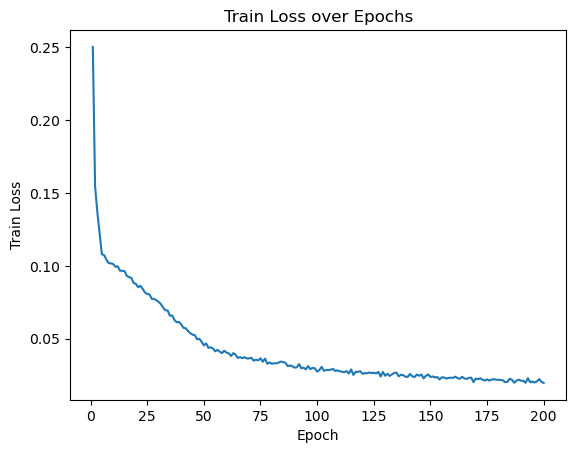

In [174]:
# Plotting the train loss
plt.plot(range(1, num_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss over Epochs')
plt.show()

In [184]:
# Load the best model
model = Classifier(input_size=7).to(device)
model.load_state_dict(torch.load(string))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    print(f"Accuracy of the saved model: {accuracy:.2f}%")


Accuracy of the saved model: 95.90%
